In [1]:
# Model Building
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For running this notebook either locally or in colab
import sys

In [2]:
%%capture
# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [3]:
  # For encoding categorical data
from category_encoders import OneHotEncoder

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# NYC Rent

**GOAL:** Improve our model for predicting NYC rent prices.

**Objectives**

- Do one-hot encoding of categorical features
- Do univariate feature selection
- Use scikit-learn to fit Ridge Regression models

# I. Wrangle Data

Create **wrangle function** for **reproducibility**.

In [4]:
def wrangle(filepath):
  df = pd.read_csv(filepath,parse_dates=['created'],
                   index_col='created').sort_index()
  
  # Remove outlier observations
  df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
          (df['price'] <= np.percentile(df['price'], 99.5)) & 
          (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
          (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
          (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
          (df['longitude'] <= np.percentile(df['longitude'], 99.95))]
  
  # # Remove high-cardinality categorical variables
  cutoff = 5
  drop_cols = [col for col in df.select_dtypes('object')
               if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

  return df

df = wrangle(DATA_PATH+'apartments/renthop-nyc.csv')

In [5]:
df.head()

,bathrooms,bedrooms,latitude,longitude,price,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-04-01 22:12:41,1.0,1,40.7302,-73.9924,3195,high,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-01 22:56:00,1.0,0,40.7576,-73.9677,2000,medium,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-01 22:57:15,2.0,3,40.7388,-73.9851,5850,high,1,1,0,1,1,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2016-04-01 23:26:07,1.0,1,40.7939,-73.9738,2745,medium,1,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2016-04-02 00:48:13,1.0,1,40.7784,-73.9491,2400,medium,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


This is code that we used during EDA to figure out how to drop high-cardinality categorical variables. 

In [ ]:
#df.select_dtypes('object').head()

In [ ]:
#df.select_dtypes('object').nunique()

Our solution using a `for` loop

In [ ]:
# drop_cols = []
# cutoff = 5

# for col in df.select_dtypes('object'):
#   if df[col].nunique() > cutoff:
#     drop_cols.append(col)

# print(drop_cols)

Our solution using a [list comprehension](https://www.w3schools.com/python/python_lists_comprehension.asp)

In [ ]:
# drop_cols = [col for col in df.select_dtypes('object')
#              if df[col].nunique() > cutoff]
# drop_cols

# II. Split Data

Split **target vector** from **feature matrix**.

In [6]:
target = 'price'
y = df[target]
X = df.drop(columns=target)

Split data into **training** and **test** sets.

(Use data from April & May 2016 to train. Use data from June 2016 to test.)

In [31]:
cutoff = '2016-06-01'
mask = X.index < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

# III. Establish Baseline

**Note:** This is a **regression** problem because we're predictiong the continuous value `'price'`.

In [8]:
y_pred = [y_train.mean()] * len(y_train)
print('Mean price:', y_train.mean())
print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Mean price: 3575.604007034292
Baseline MAE: 1201.8811133682555


# IV. Build Models

Since we have multiple transformers in our model, we can bundle them together with a predictor using a `Pipeline`.
- It can have as many transformer as you want (which will run sequentially), but a single predictor at end of pipeline.

In [21]:
# Linear regression pipeline
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    #SelectKBest(k=20),
    LinearRegression()
)

model_lr.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['interest_level'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=True, verbose=0)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [27]:
# Ridge regression pipeline
model_r = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge(alpha = 1.0)
)

model_r.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['interest_level'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=True, verbose=0)),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [33]:
train_maes = []
test_maes = []

for alpha in np.arange(0.0, 10.5, 0.5):
  print('Training model at alpha =', alpha)
  model_r = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge(alpha = alpha)
    )
  
  model_r.fit(X_train, y_train)

  train_mae = mean_absolute_error(y_train, model_r.predict(X_train))
  test_mae = mean_absolute_error(y_test, model_r.predict(X_test))

  train_maes.append(train_mae)
  test_maes.append(test_mae)

Training model at alpha = 0.0
Training model at alpha = 0.5


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Training model at alpha = 1.0
Training model at alpha = 1.5


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Training model at alpha = 2.0
Training model at alpha = 2.5


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Training model at alpha = 3.0
Training model at alpha = 3.5


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Training model at alpha = 4.0
Training model at alpha = 4.5


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Training model at alpha = 5.0
Training model at alpha = 5.5


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Training model at alpha = 6.0
Training model at alpha = 6.5


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Training model at alpha = 7.0
Training model at alpha = 7.5


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Training model at alpha = 8.0
Training model at alpha = 8.5


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Training model at alpha = 9.0
Training model at alpha = 9.5


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Training model at alpha = 10.0


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


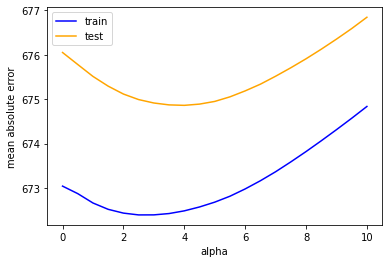

In [38]:
# Visualize validation curves
plt.plot(np.arange(0.0, 10.5, 0.5), train_maes, color = 'blue', label = 'train')
plt.plot(np.arange(0.0, 10.5, 0.5), test_maes, color = 'orange', label = 'test')
plt.xlabel('alpha')
plt.ylabel('mean absolute error')
plt.legend();

# V. Check Metrics

In [12]:
print('LR training MAE:', mean_absolute_error(y_train, model_lr.predict(X_train)))
print('LR test MAE:', mean_absolute_error(y_test, model_lr.predict(X_test)))

LR training MAE: 674.6613258963888
LR test MAE: 676.3303237959038


In [13]:
print('Ridge training MAE:', mean_absolute_error(y_train, model_r.predict(X_train)))
print('Ridge test MAE:', mean_absolute_error(y_test, model_r.predict(X_test)))

Ridge training MAE: 672.6640726589892
Ridge test MAE: 675.5149089564062


In [ ]:
print('LR training MAE:', mean_absolute_error(y_train, model_lr2.predict(XTT_train)))
print('LR test MAE:', mean_absolute_error(y_test, model_lr2.predict(XTT_test)))

LR training MAE: 680.5416962296824
LR test MAE: 683.9187094294459


# Communicate results

In [19]:
type(model_lr.named_steps['onehotencoder'].get_feature_names())

list

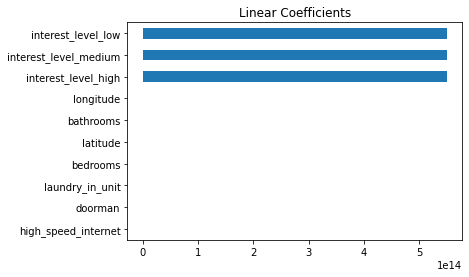

In [23]:
feature_names = model_lr.named_steps['onehotencoder'].get_feature_names()

coefficients = model_lr.named_steps['linearregression'].coef_


feature_importances = pd.Series(coefficients, index=feature_names).sort_values(key=abs)
feature_importances.tail(10).plot(kind='barh', title='Linear Coefficients')

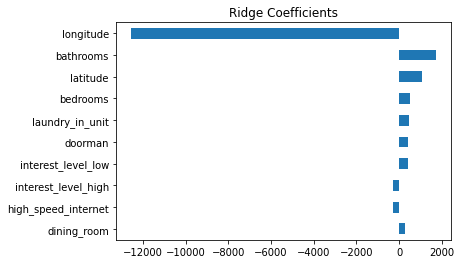

In [28]:
feature_names = model_r.named_steps['onehotencoder'].get_feature_names()
coefficients = model_r.named_steps['ridge'].coef_
feature_importances = pd.Series(coefficients, index=feature_names).sort_values(key=abs)
feature_importances.tail(10).plot(kind='barh', title='Ridge Coefficients')